In [46]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42433")

# Import

In [2]:
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
from IPython import display
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint,Callback
import inspect
import itertools
import matplotlib.colors as mcolors
import glob, os
from random import randrange

In [3]:
import myParam3Ddata
import myTorchModels3D

In [4]:
import importlib

In [5]:
importlib.reload(myParam3Ddata)

<module 'myParam3Ddata' from '/home/jovyan/oceanDataNotebooks/density_ML/myParam3Ddata.py'>

# Prepare data

In [6]:
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET'] 

In [7]:
data_dict=[dict() for i in range(6)]
data_dict[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR FMA'})
data_dict[1] = dict({'region' : '1', 'season' : 'aso', 'label' : 'GULFSTR ASO'})
data_dict[2] = dict({'region' : '2', 'season' : 'fma', 'label' : 'MIDATL FMA'})
data_dict[3] = dict({'region' : '2', 'season' : 'aso', 'label' : 'MIDATL ASO'})
data_dict[4] = dict({'region' : '3', 'season' : 'fma', 'label' : 'WESTMED FMA'})
data_dict[5] = dict({'region' : '3', 'season' : 'aso', 'label' : 'WESTMED ASO'})

In [8]:
features_to_add_to_sample = ['votemper', 'votemper_var', 'rho_ct_ct', 'diff_votemper_sqr']

In [9]:
auxiliary_features = ['z_l', 'f', 'e1t', 'e2t']

In [10]:
batch_size = 4

In [11]:
%%time
all_data = myParam3Ddata.PyLiDataModule(data_dict, features_to_add_to_sample, auxiliary_features, batch_size=batch_size)

CPU times: user 16.5 s, sys: 4.59 s, total: 21.1 s
Wall time: 1min 46s


# Average with convolutions

In [241]:
def avg_conv(data) :
    weights = torch.ones(1,1,3,3) #matrix 3x3 filled with ones
    padding = torch.nn.ReplicationPad2d(1)  #pad borders with 1 row/column with the replicated values
    padded_data = padding(data)
    average3x3_flatten = torch.nn.functional.conv2d(padded_data.flatten(start_dim=0, end_dim=1)[:,None,:,:], \
                           weights, \
                           bias=None, stride=1, padding='valid', dilation=1, groups=1)

    average3x3_unflatten = average3x3_flatten[:,0,:,:].unflatten(dim=0, sizes=(batch_len, nb_levels))
    return average3x3_unflatten

# Non-dimensionalization

In [385]:
in_data = dict()

In [386]:
in_data['raw'] = sample['votemper']
in_data['nondim_stat'] = ((sample['votemper']-sample['mean_votemper'][:,:,None,None])/sample['std_votemper'][:,:,None,None])
in_data['nondim_diffs'] = ((sample['votemper']-sample['mean_votemper'][:,:,None,None])/torch.sqrt(sample['diff_votemper_sqr']))
in_data['nondim_by_avg'] = ((sample['votemper']-sample['mean_votemper'][:,:,None,None])/torch.sqrt(avg_conv(sample['diff_votemper_sqr'])))

In [387]:
out_data = dict()

In [433]:
out_data['raw'] = sample['votemper_var']
out_data['nondim_stat'] = (sample['votemper_var']/sample['std_diff_votemper_sqr'][:,:,None,None])
out_data['nondim_diffs'] = (sample['votemper_var']/sample['diff_votemper_sqr'])
out_data['nondim_by_avg'] = (sample['votemper_var']/avg_conv(sample['diff_votemper_sqr']))

# Contours

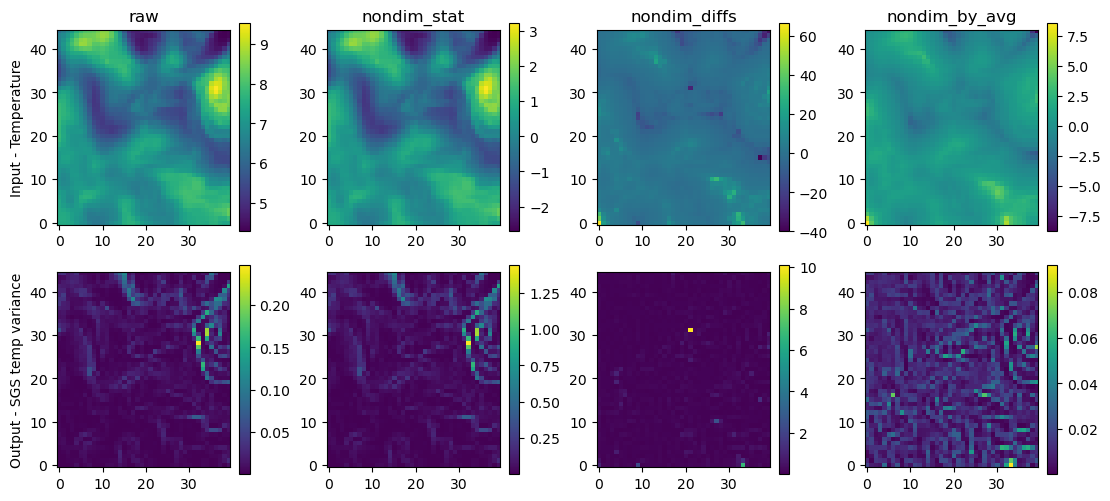

In [434]:
fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(11, 5.))
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    img = ax[0,col].imshow(in_data[transform][index,-1,:,:], origin='lower')
    fig.colorbar(img, ax=ax[0,col])
    
    img = ax[1,col].imshow(out_data[transform][index,-1,:,:], origin='lower')
    fig.colorbar(img, ax=ax[1,col])    
    
    ax[0,col].set(title=transform)
ax[0,0].set(ylabel='Input - Temperature')
ax[1,0].set(ylabel='Output - SGS temp variance')
    
plt.show()

# Histograms

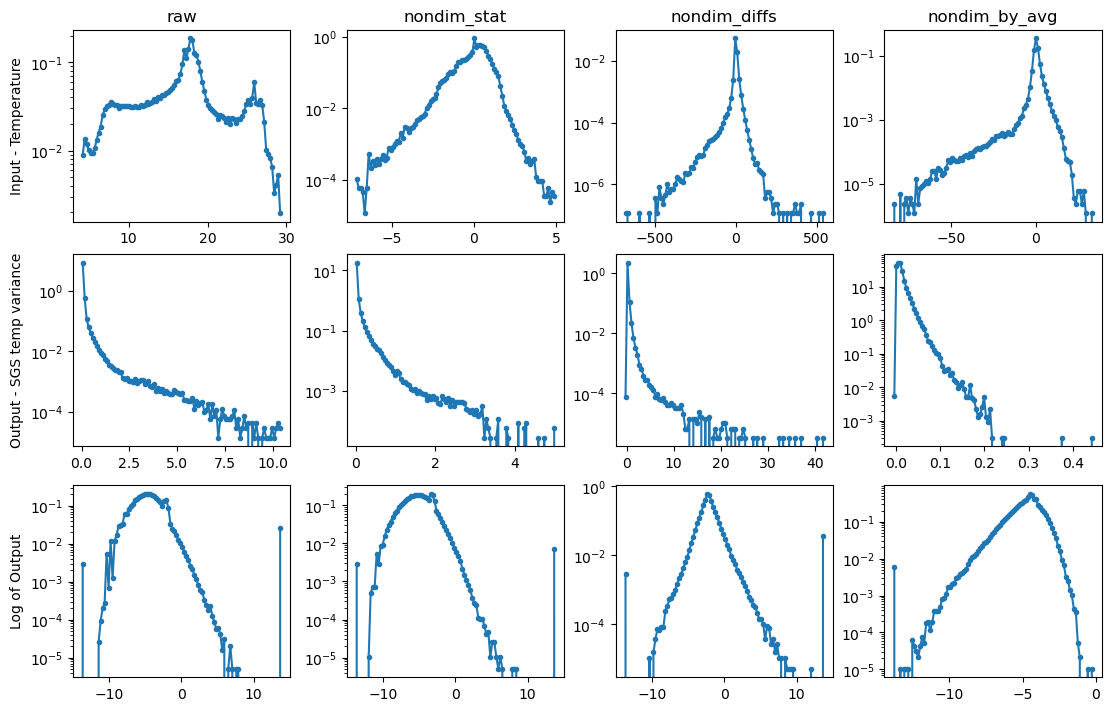

In [435]:
fig, ax = plt.subplots(3, 4, constrained_layout=True, figsize=(11, 7.))
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    hist = torch.histogram(in_data[transform][:,:,1:-1,1:-1], bins=100, density=True)
    bin_centers = 0.5*(hist.bin_edges[0:-1]+hist.bin_edges[1:])
    ax[0,col].plot(bin_centers, hist.hist, marker='.')
    ax[0,col].set(title=transform, yscale='log')
    
    hist = torch.histogram(out_data[transform][:,:,1:-1,1:-1], bins=100, density=True)
    bin_centers = 0.5*(hist.bin_edges[0:-1]+hist.bin_edges[1:])
    ax[1,col].plot(bin_centers, hist.hist, marker='.')
    ax[1,col].set(yscale='log')
    
    hist = torch.histogram(torch.logit(out_data[transform][:,:,1:-1,1:-1], eps=1e-6), bins=100, density=True)
    bin_centers = 0.5*(hist.bin_edges[0:-1]+hist.bin_edges[1:])
    ax[2,col].plot(bin_centers, hist.hist, marker='.')
    ax[2,col].set(yscale='log')
ax[0,0].set(ylabel='Input - Temperature')
ax[1,0].set(ylabel='Output - SGS temp variance')
ax[2,0].set(ylabel='Log of Output')
    
plt.show()

# Scatter plots

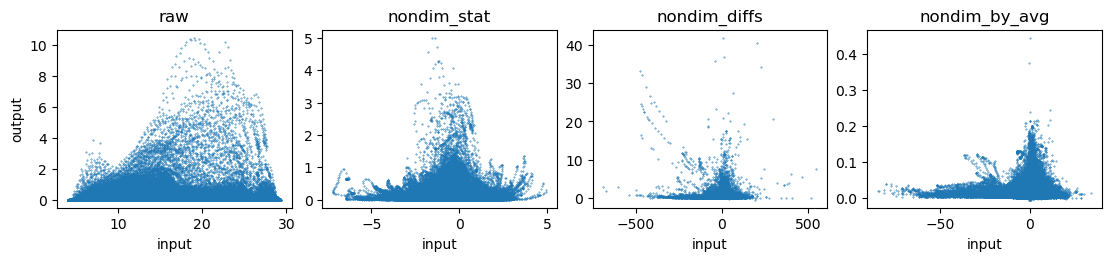

In [436]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(11, 2.5), squeeze=False)
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    ax[0,col].scatter(in_data[transform][:,:,1:-1,1:-1], out_data[transform][:,:,1:-1,1:-1], marker='.', s=0.5) 
    ax[0,col].set(title=transform)
    ax[0,col].set(xlabel='input')
ax[0,0].set(ylabel='output')
plt.show()

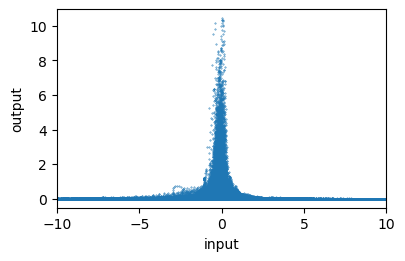

In [442]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 2.5))
index = 0

in_transform = 'nondim_by_avg' 
out_transform = 'raw'
ax.scatter(in_data[in_transform][:,:,1:-1,1:-1], out_data[out_transform][:,:,1:-1,1:-1], marker='.', s=0.5) 
ax.set(xlabel='input', ylabel='output', xlim=[-10,10])
plt.show()

# Deterministic parametrization

Differences:

In [443]:
def diff_sqr(input_data) :
    weights = torch.zeros(2,1,3,3)
    weights[0,0,:,:] = torch.tensor([[0,0.,0],[-0.5,0.,0.5],[0,0.,0]])
    weights[1,0,:,:] = torch.tensor([[0,-0.5,0],[0,0.,0],[0,0.5,0]])
    flatten_data = input_data.flatten(start_dim=0, end_dim=1)
    res = torch.nn.functional.conv2d(flatten_data[:,None,:,:], \
                           weights, \
                           bias=None, stride=1, padding='same', dilation=1, groups=1)
    res_dx = res[:,0,:,:].unflatten(dim=0, sizes=(batch_len, nb_levels))
    res_dy = res[:,1,:,:].unflatten(dim=0, sizes=(batch_len, nb_levels))
    return (torch.pow(res_dx, 2) + torch.pow(res_dy, 2))

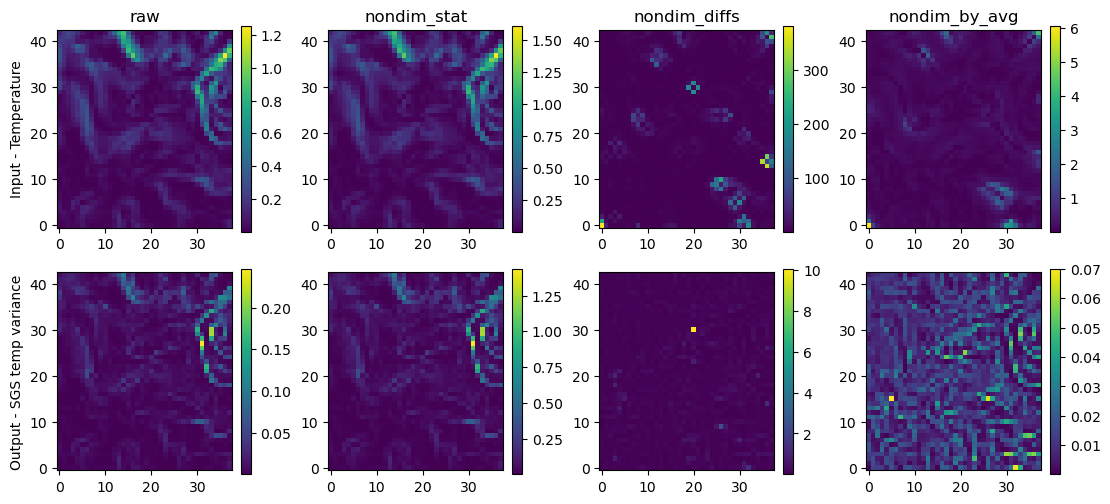

In [444]:
fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(11, 5.))
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    img = ax[0,col].imshow(diff_sqr(in_data[transform])[index,-1,1:-1,1:-1], origin='lower')
    fig.colorbar(img, ax=ax[0,col])
    
    img = ax[1,col].imshow(out_data[transform][index,-1,1:-1,1:-1], origin='lower')
    fig.colorbar(img, ax=ax[1,col])    
    
    ax[0,col].set(title=transform)
ax[0,0].set(ylabel='Input - Temperature')
ax[1,0].set(ylabel='Output - SGS temp variance')
    
plt.show()

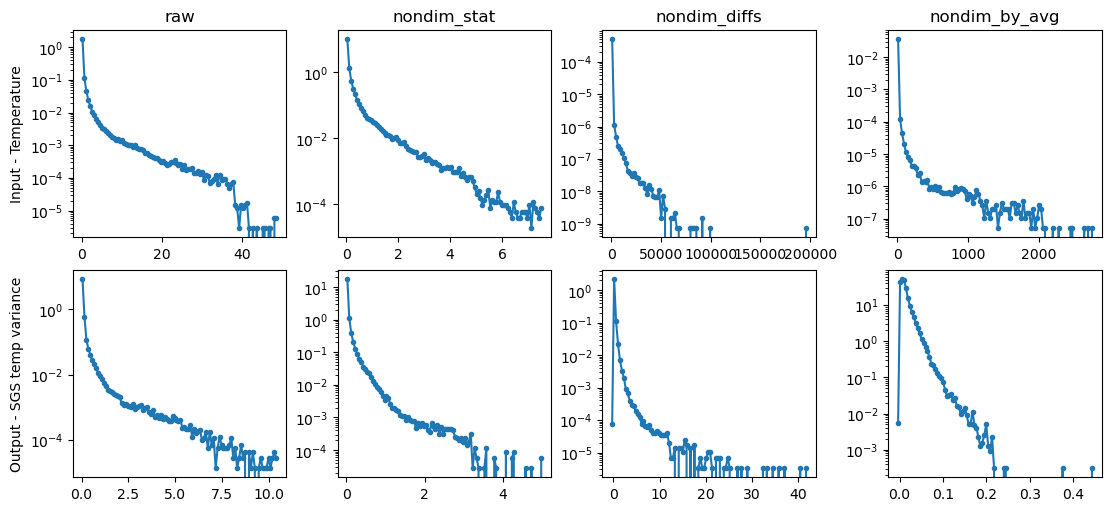

In [450]:
fig, ax = plt.subplots(2, 4, constrained_layout=True, figsize=(11, 5.))
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    hist = torch.histogram(diff_sqr(in_data[transform])[:,:,1:-1,1:-1], bins=100, density=True)
    bin_centers = 0.5*(hist.bin_edges[0:-1]+hist.bin_edges[1:])
    ax[0,col].plot(bin_centers, hist.hist, marker='.')
    ax[0,col].set(title=transform, yscale='log')
    
    hist = torch.histogram(out_data[transform][:,:,1:-1,1:-1], bins=100, density=True)
    bin_centers = 0.5*(hist.bin_edges[0:-1]+hist.bin_edges[1:])
    ax[1,col].plot(bin_centers, hist.hist, marker='.')
    ax[1,col].set(yscale='log')
ax[0,0].set(ylabel='Input - Temperature')
ax[1,0].set(ylabel='Output - SGS temp variance')
    
plt.show()

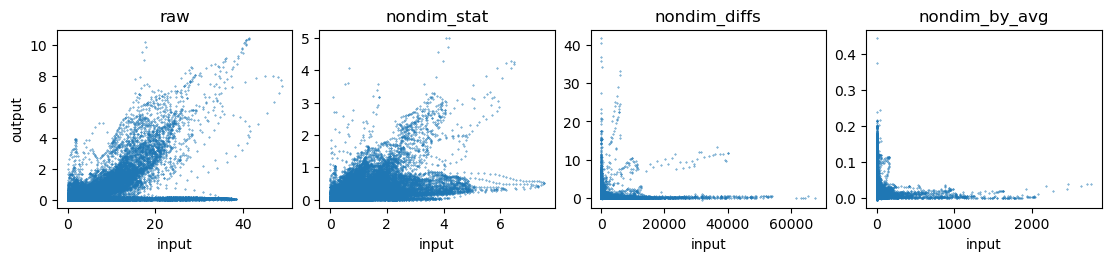

In [446]:
fig, ax = plt.subplots(1, 4, constrained_layout=True, figsize=(11, 2.5), squeeze=False)
index = 0

for col, transform in enumerate(['raw', 'nondim_stat', 'nondim_diffs', 'nondim_by_avg']) :
    ax[0,col].scatter(diff_sqr(in_data[transform])[:,:,2:-2,2:-2], out_data[transform][:,:,2:-2,2:-2], marker='.', s=0.5) 
    ax[0,col].set(title=transform)
    ax[0,col].set(xlabel='input')
ax[0,0].set(ylabel='output')
plt.show()

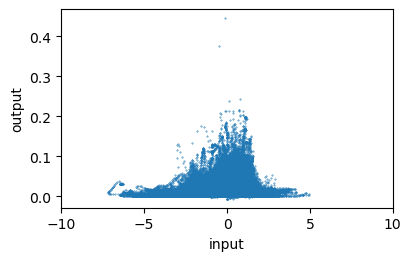

In [449]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(4, 2.5))
index = 0

in_transform = 'nondim_stat' 
out_transform = 'nondim_by_avg'
ax.scatter(in_data[in_transform][:,:,1:-1,1:-1], out_data[out_transform][:,:,1:-1,1:-1], marker='.', s=0.5) 
ax.set(xlabel='input', ylabel='output', xlim=[-10,10])
plt.show()